##### Objective:
`Given a Bank customer, build a neural network based classifier that can determine whether they will leave
or not in the next 6 months.`

##### Context:
`Businesses like banks which provide service have to worry about problem of 'Churn' i.e. customers
leaving and joining another service provider. It is important to understand which aspects of the service
influence a customer's decision in this regard. Management can concentrate efforts on improvement of
service, keeping in mind these priorities.`

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

### Read the dataset

In [3]:
df = pd.read_csv('bank.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


*Attribute Description and possible data types:*
>1. RowNumber, customerID and Surname (not relevant for model training)
>2. CreditScore : (higher score - good, lower score - poor) - continuous variables
>3. Geography : customers locations (norminal categorical variable)
>4. Gender : customers gender, male or female (norminal categorical variable)
>5. Age : (descrete positive interger) 
>6. Tenure: (descrete positive interger) 
>7. Balance: account blance (continuous variable)
>8. NumOfProducts: ordinal categorical or descrete positive interger
>9. HasCrCard: Has credit card (boleen categorical)
>10. IsActiveMember: active customers or not (boleen categorical)
>11. EstimatedSalary: Estimated salary (continuous variable)
>12. Exited: Has left or stay? (boleen categorical)

### Drop the columns which are unique for all users 

In [432]:
df = df.iloc[:,3:] # Select relevant columns using iloc function 

In [433]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


###### Quick EDA

In [434]:
print(df.shape) #shape of data set 
print()
print(df.info()) # information about variables and null values  

(10000, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


In [435]:
df.isnull().values.any() #check for null values 

False

**Check how balanced the target variablle (Exited) is.**

In [436]:
Exited_true = len(df.loc[df['Exited'] == 1]) #locate the Exited columns and find the number of entries that are equal to 1
                                            
Exited_false = len(df.loc[df['Exited'] == 0]) #locate the Existed columns and find the number of entries that are equal to 0
                                                 
print("Number of true exit cases: {0} ({1:2.2f}%)".format(Exited_true, (Exited_true / (Exited_true + Exited_false)) * 100 ))

print("Number of false exit cases: {0} ({1:2.2f}%)".format(Exited_false, (Exited_false / (Exited_true + Exited_false)) * 100))

Number of true exit cases: 2037 (20.37%)
Number of false exit cases: 7963 (79.63%)


>1.`About 20% of the customers in the bank have left to other banks while approx 80% are still banking with the bank`
>2.`The problem is not properly balanced. Effort would be gared towards improving the Recall or true positive rate along with other metrics `

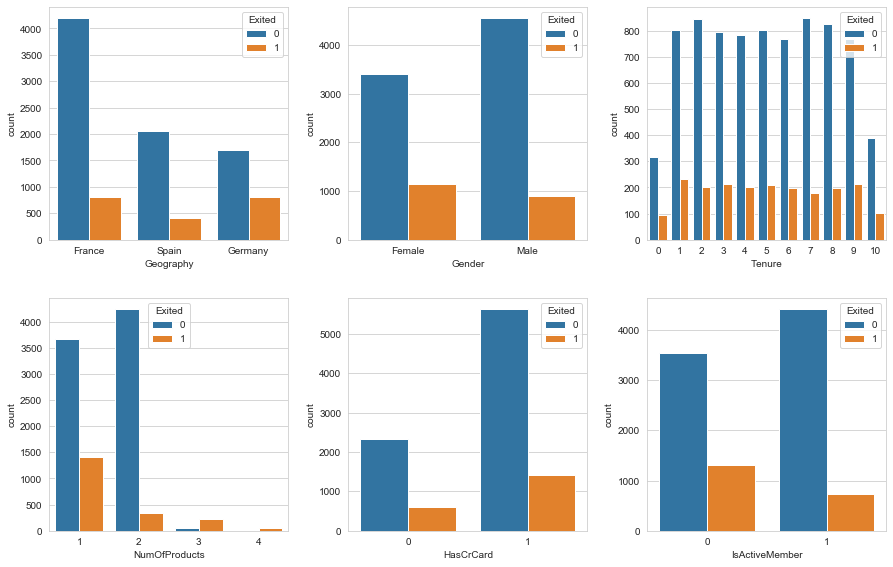

In [437]:
fig = plt.figure(figsize=[15,15])#, dpi=200)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
sns.set_style("whitegrid")
columns = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']
j = 1
for i in columns:
    ax = fig.add_subplot(3,3,j)
    sns.countplot(df[i], ax=ax, hue = df['Exited'])
    j = j+1
    if j>len(columns):
        break
plt.show()

**Observations**
`There is great room for improvement when features like 'number of product', 'HasCrCard (whether the customer has credit card or not)', and 'active membership' is strongly considered and looked into. Their impact on bank churn is strong`. 

In [438]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


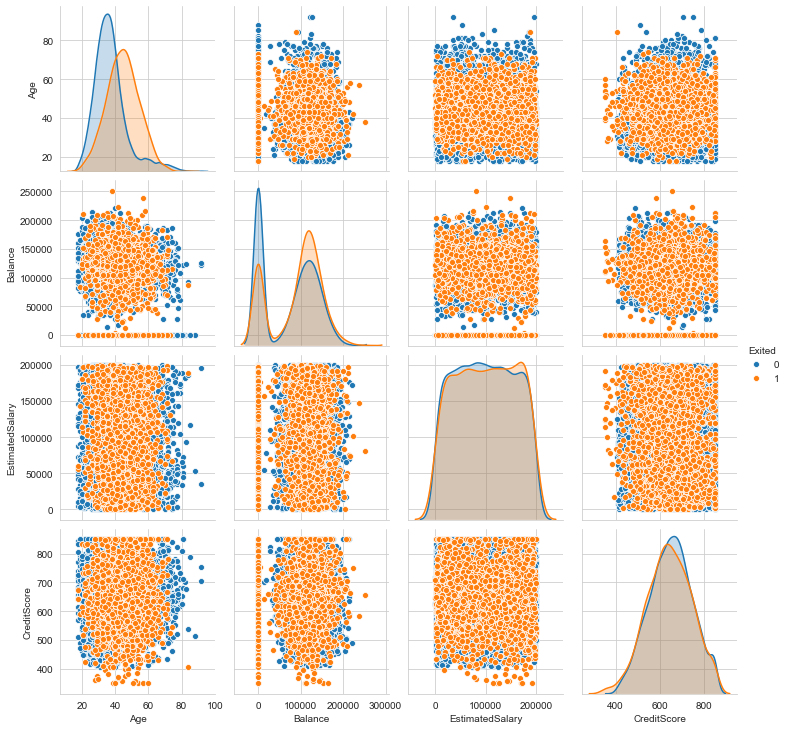

In [439]:
sns.pairplot(df[['Age','Balance','EstimatedSalary','CreditScore','Exited']] ,hue = 'Exited');

`The pairplot of the continuous variables show no clear correlation between them, hence , they are independent`

##### Prepare data by converting dummy variables into a OneHotEncoded values 

In [440]:
oneHotCols=['Geography','Gender'] #dummy columns 

In [441]:
#execute one-hot encoding for the specified variables and drop the irrelevant extra columns (drop_first = True)

df=pd.get_dummies(df, columns=oneHotCols, drop_first=True)

In [442]:
df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0


### Distinguish the features and target variable

In [443]:
X_data = df.drop('Exited', axis =1)   #independent variables 
X_data.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0


In [444]:
y_data = df['Exited']    #dependent variables (target)
y_data.head(5)

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [445]:
X_data.shape, y_data.shape

((10000, 11), (10000,))

### Divide the data set into training and test sets

In [446]:
from sklearn.model_selection import train_test_split

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 43)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 11), (2000, 11), (8000,), (2000,))

### Normalize the train and test data

In [448]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_train =scaler.fit_transform(X_train)
X_test =scaler.fit_transform(X_test)

### Initialize & build the model. Identify the points of improvement and implement the same 

In [513]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers

In [514]:
from tensorflow.keras.metrics import Recall   #to track Recall while training 
from tensorflow.keras.metrics import Precision #to track precision while training 

In [515]:
model = Sequential()   #instantiating the sequential class 

In [516]:
model.add(Dense(50, input_shape = (X_train.shape[1],) , activation = 'relu')) #input_shape is the number of input features.
model.add(Dropout(0.1))
model.add(Dense(32, activation = 'tanh')) #scaled sigmoid type model
model.add(Dropout(0.1))  
model.add(Dense(1, activation = 'sigmoid')) #to ensure a classified output

`Due to quick overfit experienced, a dropout function for reguarization was added in the cell above to improve the model` 

In [517]:
sgd = optimizers.Adam(lr = 0.001)

In [518]:
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy','Recall','Precision'])
# In addition to the metrics are Recall and Precision. This will enable real time mornitoring of model performance 

In [519]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 50)                600       
_________________________________________________________________
dropout_75 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 32)                1632      
_________________________________________________________________
dropout_76 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 33        
Total params: 2,265
Trainable params: 2,265
Non-trainable params: 0
_________________________________________________________________


##### Fitting the model

In [520]:
# validation score is included here to know when model is overfitting or underfitting. 

history=model.fit(X_train, y_train.values, batch_size = 50, epochs = 700, validation_split=0.1, verbose = 1)


Train on 7200 samples, validate on 800 samples
Epoch 1/700
7200/7200 [==============================] - 2s 212us/sample - loss: 0.4788 - accuracy: 0.7985 - Recall: 0.0239 - Precision: 0.5932 - val_loss: 0.4760 - val_accuracy: 0.7987 - val_Recall: 0.0429 - val_Precision: 0.5833
Epoch 2/700
7200/7200 [==============================] - 0s 43us/sample - loss: 0.4482 - accuracy: 0.8086 - Recall: 0.1149 - Precision: 0.6667 - val_loss: 0.4581 - val_accuracy: 0.8050 - val_Recall: 0.1595 - val_Precision: 0.5778
Epoch 3/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.4324 - accuracy: 0.8132 - Recall: 0.1737 - Precision: 0.6496 - val_loss: 0.4389 - val_accuracy: 0.8062 - val_Recall: 0.1656 - val_Precision: 0.5870
Epoch 4/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.4211 - accuracy: 0.8222 - Recall: 0.2332 - Precision: 0.6820 - val_loss: 0.4294 - val_accuracy: 0.8138 - val_Recall: 0.2025 - val_Precision: 0.6346
Epoch 5/700
7200/7200 [=========

7200/7200 [==============================] - 0s 40us/sample - loss: 0.3347 - accuracy: 0.8608 - Recall: 0.4767 - Precision: 0.7463 - val_loss: 0.3540 - val_accuracy: 0.8562 - val_Recall: 0.3865 - val_Precision: 0.8077
Epoch 72/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3359 - accuracy: 0.8612 - Recall: 0.4720 - Precision: 0.7525 - val_loss: 0.3499 - val_accuracy: 0.8550 - val_Recall: 0.4172 - val_Precision: 0.7640
Epoch 73/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3350 - accuracy: 0.8611 - Recall: 0.4569 - Precision: 0.7643 - val_loss: 0.3574 - val_accuracy: 0.8562 - val_Recall: 0.3620 - val_Precision: 0.8429
Epoch 74/700
7200/7200 [==============================] - 0s 45us/sample - loss: 0.3327 - accuracy: 0.8635 - Recall: 0.4726 - Precision: 0.7652 - val_loss: 0.3548 - val_accuracy: 0.8487 - val_Recall: 0.4294 - val_Precision: 0.7143
Epoch 75/700
7200/7200 [==============================] - 0s 42us/sample - loss: 0.3331 -

7200/7200 [==============================] - 0s 38us/sample - loss: 0.3244 - accuracy: 0.8647 - Recall: 0.4877 - Precision: 0.7601 - val_loss: 0.3598 - val_accuracy: 0.8587 - val_Recall: 0.4785 - val_Precision: 0.7358
Epoch 142/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3280 - accuracy: 0.8649 - Recall: 0.4822 - Precision: 0.7655 - val_loss: 0.3538 - val_accuracy: 0.8650 - val_Recall: 0.3988 - val_Precision: 0.8667
Epoch 143/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3270 - accuracy: 0.8657 - Recall: 0.4802 - Precision: 0.7723 - val_loss: 0.3563 - val_accuracy: 0.8600 - val_Recall: 0.3926 - val_Precision: 0.8312
Epoch 144/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3223 - accuracy: 0.8660 - Recall: 0.4870 - Precision: 0.7681 - val_loss: 0.3608 - val_accuracy: 0.8562 - val_Recall: 0.3988 - val_Precision: 0.7927
Epoch 145/700
7200/7200 [==============================] - 0s 37us/sample - loss: 0.32

7200/7200 [==============================] - 0s 38us/sample - loss: 0.3222 - accuracy: 0.8700 - Recall: 0.4993 - Precision: 0.7816 - val_loss: 0.3572 - val_accuracy: 0.8637 - val_Recall: 0.4417 - val_Precision: 0.8000
Epoch 212/700
7200/7200 [==============================] - 0s 35us/sample - loss: 0.3189 - accuracy: 0.8682 - Recall: 0.5041 - Precision: 0.7669 - val_loss: 0.3538 - val_accuracy: 0.8612 - val_Recall: 0.4540 - val_Precision: 0.7708
Epoch 213/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3221 - accuracy: 0.8683 - Recall: 0.5062 - Precision: 0.7660 - val_loss: 0.3620 - val_accuracy: 0.8662 - val_Recall: 0.4172 - val_Precision: 0.8500
Epoch 214/700
7200/7200 [==============================] - 0s 37us/sample - loss: 0.3216 - accuracy: 0.8656 - Recall: 0.4829 - Precision: 0.7691 - val_loss: 0.3555 - val_accuracy: 0.8637 - val_Recall: 0.4294 - val_Precision: 0.8140
Epoch 215/700
7200/7200 [==============================] - 0s 35us/sample - loss: 0.32

7200/7200 [==============================] - 0s 36us/sample - loss: 0.3143 - accuracy: 0.8697 - Recall: 0.5096 - Precision: 0.7712 - val_loss: 0.3526 - val_accuracy: 0.8625 - val_Recall: 0.4172 - val_Precision: 0.8193
Epoch 282/700
7200/7200 [==============================] - 0s 37us/sample - loss: 0.3144 - accuracy: 0.8692 - Recall: 0.5171 - Precision: 0.7621 - val_loss: 0.3510 - val_accuracy: 0.8662 - val_Recall: 0.4663 - val_Precision: 0.7917
Epoch 283/700
7200/7200 [==============================] - 0s 33us/sample - loss: 0.3163 - accuracy: 0.8681 - Recall: 0.5150 - Precision: 0.7575 - val_loss: 0.3530 - val_accuracy: 0.8637 - val_Recall: 0.3865 - val_Precision: 0.8750
Epoch 284/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3180 - accuracy: 0.8685 - Recall: 0.5109 - Precision: 0.7630 - val_loss: 0.3490 - val_accuracy: 0.8662 - val_Recall: 0.4356 - val_Precision: 0.8256
Epoch 285/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.32

7200/7200 [==============================] - 0s 37us/sample - loss: 0.3147 - accuracy: 0.8724 - Recall: 0.5192 - Precision: 0.7785 - val_loss: 0.3494 - val_accuracy: 0.8650 - val_Recall: 0.4969 - val_Precision: 0.7570
Epoch 352/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3150 - accuracy: 0.8692 - Recall: 0.5212 - Precision: 0.7590 - val_loss: 0.3534 - val_accuracy: 0.8637 - val_Recall: 0.4172 - val_Precision: 0.8293
Epoch 353/700
7200/7200 [==============================] - 0s 35us/sample - loss: 0.3119 - accuracy: 0.8731 - Recall: 0.5342 - Precision: 0.7702 - val_loss: 0.3506 - val_accuracy: 0.8687 - val_Recall: 0.4540 - val_Precision: 0.8222
Epoch 354/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3125 - accuracy: 0.8708 - Recall: 0.5164 - Precision: 0.7720 - val_loss: 0.3515 - val_accuracy: 0.8650 - val_Recall: 0.4479 - val_Precision: 0.8022
Epoch 355/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.31

7200/7200 [==============================] - 0s 36us/sample - loss: 0.3104 - accuracy: 0.8700 - Recall: 0.5301 - Precision: 0.7568 - val_loss: 0.3507 - val_accuracy: 0.8637 - val_Recall: 0.4356 - val_Precision: 0.8068
Epoch 422/700
7200/7200 [==============================] - 0s 33us/sample - loss: 0.3083 - accuracy: 0.8747 - Recall: 0.5369 - Precision: 0.7772 - val_loss: 0.3508 - val_accuracy: 0.8700 - val_Recall: 0.4540 - val_Precision: 0.8315
Epoch 423/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3092 - accuracy: 0.8718 - Recall: 0.5376 - Precision: 0.7609 - val_loss: 0.3441 - val_accuracy: 0.8725 - val_Recall: 0.4908 - val_Precision: 0.8081
Epoch 424/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3078 - accuracy: 0.8740 - Recall: 0.5321 - Precision: 0.7772 - val_loss: 0.3457 - val_accuracy: 0.8662 - val_Recall: 0.4724 - val_Precision: 0.7857
Epoch 425/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.30

7200/7200 [==============================] - 0s 34us/sample - loss: 0.3059 - accuracy: 0.8721 - Recall: 0.5301 - Precision: 0.7681 - val_loss: 0.3424 - val_accuracy: 0.8675 - val_Recall: 0.4724 - val_Precision: 0.7938
Epoch 492/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3080 - accuracy: 0.8735 - Recall: 0.5308 - Precision: 0.7752 - val_loss: 0.3443 - val_accuracy: 0.8712 - val_Recall: 0.4417 - val_Precision: 0.8571
Epoch 493/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3040 - accuracy: 0.8765 - Recall: 0.5356 - Precision: 0.7885 - val_loss: 0.3488 - val_accuracy: 0.8637 - val_Recall: 0.4233 - val_Precision: 0.8214
Epoch 494/700
7200/7200 [==============================] - 0s 35us/sample - loss: 0.3026 - accuracy: 0.8757 - Recall: 0.5506 - Precision: 0.7718 - val_loss: 0.3415 - val_accuracy: 0.8737 - val_Recall: 0.4908 - val_Precision: 0.8163
Epoch 495/700
7200/7200 [==============================] - 0s 35us/sample - loss: 0.30

7200/7200 [==============================] - 0s 34us/sample - loss: 0.3019 - accuracy: 0.8731 - Recall: 0.5342 - Precision: 0.7702 - val_loss: 0.3447 - val_accuracy: 0.8687 - val_Recall: 0.4479 - val_Precision: 0.8295
Epoch 562/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3013 - accuracy: 0.8739 - Recall: 0.5404 - Precision: 0.7700 - val_loss: 0.3467 - val_accuracy: 0.8712 - val_Recall: 0.4601 - val_Precision: 0.8333
Epoch 563/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3014 - accuracy: 0.8788 - Recall: 0.5520 - Precision: 0.7873 - val_loss: 0.3534 - val_accuracy: 0.8675 - val_Recall: 0.4724 - val_Precision: 0.7938
Epoch 564/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.3005 - accuracy: 0.8750 - Recall: 0.5424 - Precision: 0.7744 - val_loss: 0.3435 - val_accuracy: 0.8687 - val_Recall: 0.5215 - val_Precision: 0.7589
Epoch 565/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.30

7200/7200 [==============================] - 0s 34us/sample - loss: 0.3002 - accuracy: 0.8778 - Recall: 0.5424 - Precision: 0.7898 - val_loss: 0.3453 - val_accuracy: 0.8687 - val_Recall: 0.5031 - val_Precision: 0.7736
Epoch 632/700
7200/7200 [==============================] - 0s 35us/sample - loss: 0.3005 - accuracy: 0.8743 - Recall: 0.5410 - Precision: 0.7717 - val_loss: 0.3431 - val_accuracy: 0.8700 - val_Recall: 0.5092 - val_Precision: 0.7757
Epoch 633/700
7200/7200 [==============================] - 0s 34us/sample - loss: 0.3021 - accuracy: 0.8796 - Recall: 0.5506 - Precision: 0.7931 - val_loss: 0.3419 - val_accuracy: 0.8712 - val_Recall: 0.5337 - val_Precision: 0.7632
Epoch 634/700
7200/7200 [==============================] - 0s 33us/sample - loss: 0.3023 - accuracy: 0.8726 - Recall: 0.5369 - Precision: 0.7659 - val_loss: 0.3470 - val_accuracy: 0.8700 - val_Recall: 0.4479 - val_Precision: 0.8391
Epoch 635/700
7200/7200 [==============================] - 0s 36us/sample - loss: 0.30

`Real time monitoring of the various metrics to ensure the final model is good for use was activated by including the both the validation and training metrics`

##### Training Evaluations 

In [521]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

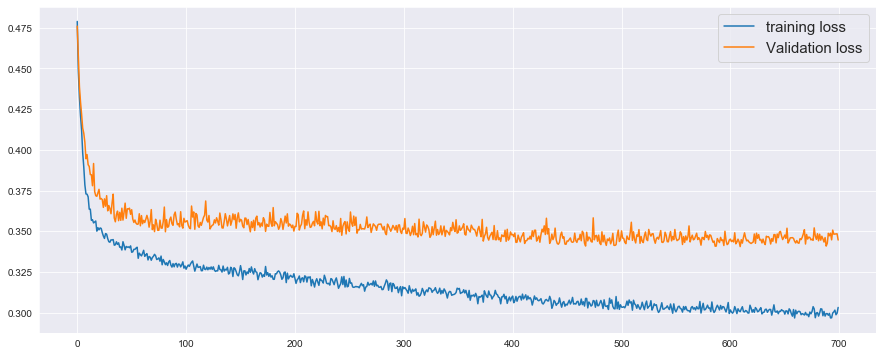

In [522]:
# plot history of training and validation loss to track the model performance in real time 
fig = plt.figure(figsize=[15,6])
sns.set_style('darkgrid')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(fontsize=15)
plt.show()

`The above plot is the best that could be gotten in an effort to prevent overfitting. Most scenario ran shows overfitting (increasing validation loss with decreasing training loss) when trying to improve the metrics.`

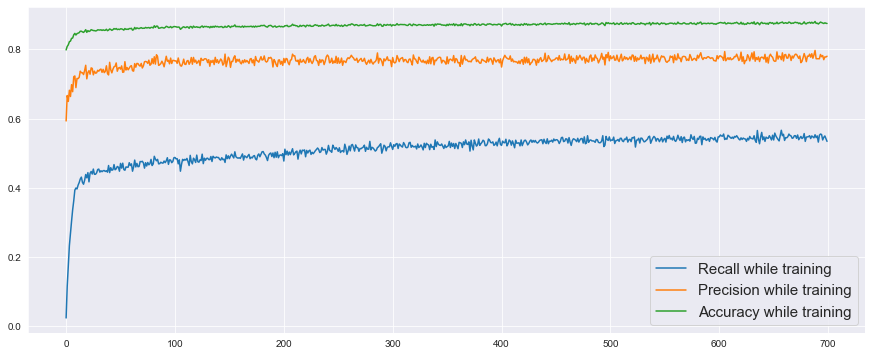

In [523]:
# plot history of training metrics to show how they evolves with each Epoch.
fig = plt.figure(figsize=[15,6])
sns.set_style('darkgrid')
plt.plot(history.history['Recall'], label='Recall while training')
plt.plot(history.history['Precision'], label='Precision while training')
plt.plot(history.history['accuracy'], label='Accuracy while training')
plt.legend(fontsize=15)
plt.show()

**training evaluation score**

In [524]:
results = model.evaluate(X_train, y_train.values, verbose=0)
print('training loss is {}'.format(results[0]))
print()
print('training Accuracy is {}'.format(results[1]))
print()
print('training Recall is {}'.format(results[2]))
print()
print('training Precision is {}'.format(results[3]))
print()
print('training F1 Score is {}'.format(2*((results[2])*(results[3]))/(results[2]+results[3])))

training loss is 0.28872051295638085

training Accuracy is 0.8824999928474426

training Recall is 0.5593846440315247

training Precision is 0.8022947907447815

training F1 Score is 0.6591733314540172


`Recall was poor in the training set and would need improvement`

**testing score evaluation score**

In [525]:
results = model.evaluate(X_test, y_test.values, verbose=0)
print('test loss is {}'.format(results[0]))
print()
print('test Accuracy is {}'.format(results[1]))
print()
print('test Recall is {}'.format(results[2]))
print()
print('test Precision is {}'.format(results[3]))
print()
print('test F1 Score is {}'.format(2*((results[2])*(results[3]))/(results[2]+results[3])))

test loss is 0.35286476969718933

test Accuracy is 0.8504999876022339

test Recall is 0.5097087621688843

test Precision is 0.6840391159057617

test F1 Score is 0.5841446819380653


`With multiple trials made, the best metrics on test data is seen in the cell above. There is room for improvement as the imbalanced class is responsible for the relatively low recall.`

#### Upsampling Smaller class using SMOT(Synthetic Minority Oversampling Technique) to Check for Model Improvement 

In [526]:
from imblearn.over_sampling import SMOTE

*The training data shall be resampled upward for classes = 1*

In [527]:
print("Before UpSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) #y_train.ravel() change the data into a single dim array


print("After UpSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))



print('After UpSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_res.shape))


Before UpSampling, counts of label '1': 1625
Before UpSampling, counts of label '0': 6375 

After UpSampling, counts of label '1': 6375
After UpSampling, counts of label '0': 6375 

After UpSampling, the shape of train_X: (12750, 11)
After UpSampling, the shape of train_y: (12750,) 



In [528]:
model1 = Sequential()   #instantiating the sequential class 

In [529]:
model1.add(Dense(120, input_shape = (X_train_res.shape[1],) , activation = 'relu')) 
model1.add(Dropout(0.3))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(Dense(32, activation = 'tanh')) 
model1.add(Dropout(0.3))
model1.add(Dense(1, activation = 'sigmoid')) 

In [530]:
sgd1 = optimizers.Adam(lr = 0.001)

In [531]:
model1.compile(optimizer = sgd1, loss = 'binary_crossentropy', metrics=['accuracy','Recall','Precision'])
# In addition to the metrics are Recall and Precision. This will enable real time mornitoring of model performance 

In [532]:
history1=model1.fit(X_train_res, y_train_res, batch_size = 50, epochs = 2500, validation_split=0.1, verbose = 1)
# validation score is included here to know when model is overfitting or underfitting. 

Train on 11475 samples, validate on 1275 samples
Epoch 1/2500
11475/11475 [==============================] - 2s 213us/sample - loss: 0.6384 - accuracy: 0.6349 - Recall: 0.4700 - Precision: 0.6173 - val_loss: 0.6502 - val_accuracy: 0.6651 - val_Recall: 0.6651 - val_Precision: 1.0000
Epoch 2/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.5866 - accuracy: 0.6906 - Recall: 0.6047 - Precision: 0.6678 - val_loss: 0.6601 - val_accuracy: 0.6251 - val_Recall: 0.6251 - val_Precision: 1.0000
Epoch 3/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.5431 - accuracy: 0.7253 - Recall: 0.6510 - Precision: 0.7076 - val_loss: 0.5800 - val_accuracy: 0.6980 - val_Recall: 0.6980 - val_Precision: 1.0000
Epoch 4/2500
11475/11475 [==============================] - 1s 65us/sample - loss: 0.5063 - accuracy: 0.7528 - Recall: 0.6929 - Precision: 0.7355 - val_loss: 0.7034 - val_accuracy: 0.6016 - val_Recall: 0.6016 - val_Precision: 1.0000
Epoch 5/2500
11475

Epoch 36/2500
11475/11475 [==============================] - 1s 66us/sample - loss: 0.4028 - accuracy: 0.8153 - Recall: 0.7898 - Precision: 0.7937 - val_loss: 0.4747 - val_accuracy: 0.7592 - val_Recall: 0.7592 - val_Precision: 1.0000
Epoch 37/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.4031 - accuracy: 0.8155 - Recall: 0.7929 - Precision: 0.7922 - val_loss: 0.3913 - val_accuracy: 0.8471 - val_Recall: 0.8471 - val_Precision: 1.0000
Epoch 38/2500
11475/11475 [==============================] - 1s 66us/sample - loss: 0.3979 - accuracy: 0.8199 - Recall: 0.7980 - Precision: 0.7969 - val_loss: 0.4461 - val_accuracy: 0.7992 - val_Recall: 0.7992 - val_Precision: 1.0000
Epoch 39/2500
11475/11475 [==============================] - 1s 66us/sample - loss: 0.3964 - accuracy: 0.8201 - Recall: 0.8010 - Precision: 0.7957 - val_loss: 0.4343 - val_accuracy: 0.8141 - val_Recall: 0.8141 - val_Precision: 1.0000
Epoch 40/2500
11475/11475 [==============================] - 1s 

11475/11475 [==============================] - 1s 66us/sample - loss: 0.3677 - accuracy: 0.8358 - Recall: 0.8247 - Precision: 0.8095 - val_loss: 0.3501 - val_accuracy: 0.8643 - val_Recall: 0.8643 - val_Precision: 1.0000
Epoch 72/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3660 - accuracy: 0.8338 - Recall: 0.8233 - Precision: 0.8067 - val_loss: 0.3608 - val_accuracy: 0.8604 - val_Recall: 0.8604 - val_Precision: 1.0000
Epoch 73/2500
11475/11475 [==============================] - 1s 63us/sample - loss: 0.3684 - accuracy: 0.8338 - Recall: 0.8163 - Precision: 0.8110 - val_loss: 0.3827 - val_accuracy: 0.8361 - val_Recall: 0.8361 - val_Precision: 1.0000
Epoch 74/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.3670 - accuracy: 0.8384 - Recall: 0.8249 - Precision: 0.8140 - val_loss: 0.3670 - val_accuracy: 0.8549 - val_Recall: 0.8549 - val_Precision: 1.0000
Epoch 75/2500
11475/11475 [==============================] - 1s 65us/sample - 

11475/11475 [==============================] - 1s 59us/sample - loss: 0.3533 - accuracy: 0.8391 - Recall: 0.8276 - Precision: 0.8136 - val_loss: 0.4167 - val_accuracy: 0.8220 - val_Recall: 0.8220 - val_Precision: 1.0000
Epoch 107/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.3497 - accuracy: 0.8440 - Recall: 0.8343 - Precision: 0.8183 - val_loss: 0.3405 - val_accuracy: 0.8643 - val_Recall: 0.8643 - val_Precision: 1.0000
Epoch 108/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.3461 - accuracy: 0.8442 - Recall: 0.8337 - Precision: 0.8190 - val_loss: 0.3753 - val_accuracy: 0.8416 - val_Recall: 0.8416 - val_Precision: 1.0000
Epoch 109/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.3503 - accuracy: 0.8430 - Recall: 0.8327 - Precision: 0.8174 - val_loss: 0.3405 - val_accuracy: 0.8761 - val_Recall: 0.8761 - val_Precision: 1.0000
Epoch 110/2500
11475/11475 [==============================] - 1s 60us/sampl

Epoch 141/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.3425 - accuracy: 0.8478 - Recall: 0.8410 - Precision: 0.8210 - val_loss: 0.2951 - val_accuracy: 0.8910 - val_Recall: 0.8910 - val_Precision: 1.0000
Epoch 142/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.3445 - accuracy: 0.8484 - Recall: 0.8408 - Precision: 0.8221 - val_loss: 0.3642 - val_accuracy: 0.8596 - val_Recall: 0.8596 - val_Precision: 1.0000
Epoch 143/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.3445 - accuracy: 0.8457 - Recall: 0.8365 - Precision: 0.8199 - val_loss: 0.3236 - val_accuracy: 0.8769 - val_Recall: 0.8769 - val_Precision: 1.0000
Epoch 144/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.3361 - accuracy: 0.8512 - Recall: 0.8445 - Precision: 0.8249 - val_loss: 0.3201 - val_accuracy: 0.8824 - val_Recall: 0.8824 - val_Precision: 1.0000
Epoch 145/2500
11475/11475 [==============================] 

Epoch 176/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.3373 - accuracy: 0.8502 - Recall: 0.8465 - Precision: 0.8218 - val_loss: 0.2949 - val_accuracy: 0.9020 - val_Recall: 0.9020 - val_Precision: 1.0000
Epoch 177/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3300 - accuracy: 0.8543 - Recall: 0.8459 - Precision: 0.8296 - val_loss: 0.3077 - val_accuracy: 0.8847 - val_Recall: 0.8847 - val_Precision: 1.0000
Epoch 178/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.3273 - accuracy: 0.8534 - Recall: 0.8512 - Precision: 0.8247 - val_loss: 0.3358 - val_accuracy: 0.8651 - val_Recall: 0.8651 - val_Precision: 1.0000
Epoch 179/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.3316 - accuracy: 0.8513 - Recall: 0.8461 - Precision: 0.8241 - val_loss: 0.3442 - val_accuracy: 0.8557 - val_Recall: 0.8557 - val_Precision: 1.0000
Epoch 180/2500
11475/11475 [==============================] 

Epoch 211/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.3251 - accuracy: 0.8575 - Recall: 0.8469 - Precision: 0.8349 - val_loss: 0.3010 - val_accuracy: 0.9098 - val_Recall: 0.9098 - val_Precision: 1.0000
Epoch 212/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.3224 - accuracy: 0.8588 - Recall: 0.8586 - Precision: 0.8297 - val_loss: 0.3026 - val_accuracy: 0.8871 - val_Recall: 0.8871 - val_Precision: 1.0000
Epoch 213/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.3263 - accuracy: 0.8551 - Recall: 0.8510 - Precision: 0.8278 - val_loss: 0.3285 - val_accuracy: 0.8682 - val_Recall: 0.8682 - val_Precision: 1.0000
Epoch 214/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.3254 - accuracy: 0.8540 - Recall: 0.8475 - Precision: 0.8281 - val_loss: 0.2961 - val_accuracy: 0.8902 - val_Recall: 0.8902 - val_Precision: 1.0000
Epoch 215/2500
11475/11475 [==============================] 

Epoch 246/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.3161 - accuracy: 0.8611 - Recall: 0.8524 - Precision: 0.8379 - val_loss: 0.2821 - val_accuracy: 0.9035 - val_Recall: 0.9035 - val_Precision: 1.0000
Epoch 247/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.3208 - accuracy: 0.8560 - Recall: 0.8484 - Precision: 0.8312 - val_loss: 0.2878 - val_accuracy: 0.9043 - val_Recall: 0.9043 - val_Precision: 1.0000
Epoch 248/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.3241 - accuracy: 0.8603 - Recall: 0.8547 - Precision: 0.8349 - val_loss: 0.2894 - val_accuracy: 0.9020 - val_Recall: 0.9020 - val_Precision: 1.0000
Epoch 249/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.3125 - accuracy: 0.8622 - Recall: 0.8582 - Precision: 0.8361 - val_loss: 0.3104 - val_accuracy: 0.8745 - val_Recall: 0.8745 - val_Precision: 1.0000
Epoch 250/2500
11475/11475 [==============================] 

Epoch 281/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.3138 - accuracy: 0.8626 - Recall: 0.8614 - Precision: 0.8347 - val_loss: 0.2937 - val_accuracy: 0.9027 - val_Recall: 0.9027 - val_Precision: 1.0000
Epoch 282/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.3162 - accuracy: 0.8601 - Recall: 0.8549 - Precision: 0.8344 - val_loss: 0.2713 - val_accuracy: 0.9129 - val_Recall: 0.9129 - val_Precision: 1.0000
Epoch 283/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.3152 - accuracy: 0.8624 - Recall: 0.8590 - Precision: 0.8359 - val_loss: 0.2909 - val_accuracy: 0.8988 - val_Recall: 0.8988 - val_Precision: 1.0000
Epoch 284/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.3145 - accuracy: 0.8621 - Recall: 0.8588 - Precision: 0.8356 - val_loss: 0.3011 - val_accuracy: 0.8925 - val_Recall: 0.8925 - val_Precision: 1.0000
Epoch 285/2500
11475/11475 [==============================] 

Epoch 316/2500
11475/11475 [==============================] - 1s 67us/sample - loss: 0.3085 - accuracy: 0.8664 - Recall: 0.8651 - Precision: 0.8393 - val_loss: 0.2608 - val_accuracy: 0.9137 - val_Recall: 0.9137 - val_Precision: 1.0000
Epoch 317/2500
11475/11475 [==============================] - 1s 72us/sample - loss: 0.3077 - accuracy: 0.8680 - Recall: 0.8690 - Precision: 0.8396 - val_loss: 0.2967 - val_accuracy: 0.8910 - val_Recall: 0.8910 - val_Precision: 1.0000
Epoch 318/2500
11475/11475 [==============================] - 1s 65us/sample - loss: 0.3104 - accuracy: 0.8627 - Recall: 0.8633 - Precision: 0.8336 - val_loss: 0.2770 - val_accuracy: 0.8996 - val_Recall: 0.8996 - val_Precision: 1.0000
Epoch 319/2500
11475/11475 [==============================] - 1s 66us/sample - loss: 0.3063 - accuracy: 0.8665 - Recall: 0.8616 - Precision: 0.8418 - val_loss: 0.2889 - val_accuracy: 0.8824 - val_Recall: 0.8824 - val_Precision: 1.0000
Epoch 320/2500
11475/11475 [==============================] 

Epoch 351/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.3146 - accuracy: 0.8625 - Recall: 0.8575 - Precision: 0.8371 - val_loss: 0.2605 - val_accuracy: 0.9200 - val_Recall: 0.9200 - val_Precision: 1.0000
Epoch 352/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3068 - accuracy: 0.8667 - Recall: 0.8604 - Precision: 0.8429 - val_loss: 0.2886 - val_accuracy: 0.8910 - val_Recall: 0.8910 - val_Precision: 1.0000
Epoch 353/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3096 - accuracy: 0.8630 - Recall: 0.8604 - Precision: 0.8361 - val_loss: 0.2951 - val_accuracy: 0.8894 - val_Recall: 0.8894 - val_Precision: 1.0000
Epoch 354/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3038 - accuracy: 0.8691 - Recall: 0.8578 - Precision: 0.8492 - val_loss: 0.2700 - val_accuracy: 0.8910 - val_Recall: 0.8910 - val_Precision: 1.0000
Epoch 355/2500
11475/11475 [==============================] 

Epoch 386/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.3024 - accuracy: 0.8690 - Recall: 0.8661 - Precision: 0.8434 - val_loss: 0.3174 - val_accuracy: 0.8792 - val_Recall: 0.8792 - val_Precision: 1.0000
Epoch 387/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.3034 - accuracy: 0.8692 - Recall: 0.8676 - Precision: 0.8427 - val_loss: 0.2816 - val_accuracy: 0.8941 - val_Recall: 0.8941 - val_Precision: 1.0000
Epoch 388/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.3062 - accuracy: 0.8681 - Recall: 0.8645 - Precision: 0.8427 - val_loss: 0.2619 - val_accuracy: 0.9176 - val_Recall: 0.9176 - val_Precision: 1.0000
Epoch 389/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.3016 - accuracy: 0.8715 - Recall: 0.8702 - Precision: 0.8452 - val_loss: 0.2817 - val_accuracy: 0.9067 - val_Recall: 0.9067 - val_Precision: 1.0000
Epoch 390/2500
11475/11475 [==============================] 

Epoch 421/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.3008 - accuracy: 0.8681 - Recall: 0.8616 - Precision: 0.8448 - val_loss: 0.2762 - val_accuracy: 0.8949 - val_Recall: 0.8949 - val_Precision: 1.0000
Epoch 422/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3014 - accuracy: 0.8724 - Recall: 0.8684 - Precision: 0.8481 - val_loss: 0.2650 - val_accuracy: 0.9067 - val_Recall: 0.9067 - val_Precision: 1.0000
Epoch 423/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.3021 - accuracy: 0.8661 - Recall: 0.8598 - Precision: 0.8423 - val_loss: 0.2573 - val_accuracy: 0.9137 - val_Recall: 0.9137 - val_Precision: 1.0000
Epoch 424/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.3055 - accuracy: 0.8658 - Recall: 0.8675 - Precision: 0.8366 - val_loss: 0.2698 - val_accuracy: 0.9035 - val_Recall: 0.9035 - val_Precision: 1.0000
Epoch 425/2500
11475/11475 [==============================] 

Epoch 456/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.3028 - accuracy: 0.8695 - Recall: 0.8639 - Precision: 0.8458 - val_loss: 0.2643 - val_accuracy: 0.9122 - val_Recall: 0.9122 - val_Precision: 1.0000
Epoch 457/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.3009 - accuracy: 0.8719 - Recall: 0.8696 - Precision: 0.8464 - val_loss: 0.2814 - val_accuracy: 0.8925 - val_Recall: 0.8925 - val_Precision: 1.0000
Epoch 458/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2982 - accuracy: 0.8708 - Recall: 0.8704 - Precision: 0.8438 - val_loss: 0.2734 - val_accuracy: 0.9090 - val_Recall: 0.9090 - val_Precision: 1.0000
Epoch 459/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.3113 - accuracy: 0.8642 - Recall: 0.8582 - Precision: 0.8398 - val_loss: 0.2703 - val_accuracy: 0.9184 - val_Recall: 0.9184 - val_Precision: 1.0000
Epoch 460/2500
11475/11475 [==============================] 

Epoch 491/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2941 - accuracy: 0.8714 - Recall: 0.8710 - Precision: 0.8445 - val_loss: 0.2842 - val_accuracy: 0.8863 - val_Recall: 0.8863 - val_Precision: 1.0000
Epoch 492/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2982 - accuracy: 0.8714 - Recall: 0.8657 - Precision: 0.8481 - val_loss: 0.2854 - val_accuracy: 0.8894 - val_Recall: 0.8894 - val_Precision: 1.0000
Epoch 493/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2947 - accuracy: 0.8725 - Recall: 0.8724 - Precision: 0.8457 - val_loss: 0.2600 - val_accuracy: 0.9161 - val_Recall: 0.9161 - val_Precision: 1.0000
Epoch 494/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2997 - accuracy: 0.8707 - Recall: 0.8671 - Precision: 0.8458 - val_loss: 0.2833 - val_accuracy: 0.9075 - val_Recall: 0.9075 - val_Precision: 1.0000
Epoch 495/2500
11475/11475 [==============================] 

Epoch 526/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2894 - accuracy: 0.8759 - Recall: 0.8747 - Precision: 0.8504 - val_loss: 0.2609 - val_accuracy: 0.9184 - val_Recall: 0.9184 - val_Precision: 1.0000
Epoch 527/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2962 - accuracy: 0.8729 - Recall: 0.8761 - Precision: 0.8440 - val_loss: 0.3132 - val_accuracy: 0.8761 - val_Recall: 0.8761 - val_Precision: 1.0000
Epoch 528/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.2926 - accuracy: 0.8763 - Recall: 0.8700 - Precision: 0.8544 - val_loss: 0.2843 - val_accuracy: 0.8957 - val_Recall: 0.8957 - val_Precision: 1.0000
Epoch 529/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2915 - accuracy: 0.8736 - Recall: 0.8782 - Precision: 0.8437 - val_loss: 0.2748 - val_accuracy: 0.9098 - val_Recall: 0.9098 - val_Precision: 1.0000
Epoch 530/2500
11475/11475 [==============================] 

Epoch 561/2500
11475/11475 [==============================] - 1s 63us/sample - loss: 0.2943 - accuracy: 0.8704 - Recall: 0.8737 - Precision: 0.8409 - val_loss: 0.2673 - val_accuracy: 0.9145 - val_Recall: 0.9145 - val_Precision: 1.0000
Epoch 562/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2922 - accuracy: 0.8734 - Recall: 0.8657 - Precision: 0.8518 - val_loss: 0.2775 - val_accuracy: 0.9043 - val_Recall: 0.9043 - val_Precision: 1.0000
Epoch 563/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2890 - accuracy: 0.8764 - Recall: 0.8690 - Precision: 0.8553 - val_loss: 0.2350 - val_accuracy: 0.9176 - val_Recall: 0.9176 - val_Precision: 1.0000
Epoch 564/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2962 - accuracy: 0.8712 - Recall: 0.8665 - Precision: 0.8472 - val_loss: 0.2847 - val_accuracy: 0.9067 - val_Recall: 0.9067 - val_Precision: 1.0000
Epoch 565/2500
11475/11475 [==============================] 

Epoch 596/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2884 - accuracy: 0.8763 - Recall: 0.8714 - Precision: 0.8533 - val_loss: 0.2451 - val_accuracy: 0.9263 - val_Recall: 0.9263 - val_Precision: 1.0000
Epoch 597/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2986 - accuracy: 0.8697 - Recall: 0.8635 - Precision: 0.8464 - val_loss: 0.2672 - val_accuracy: 0.9059 - val_Recall: 0.9059 - val_Precision: 1.0000
Epoch 598/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2921 - accuracy: 0.8729 - Recall: 0.8655 - Precision: 0.8510 - val_loss: 0.2594 - val_accuracy: 0.9114 - val_Recall: 0.9114 - val_Precision: 1.0000
Epoch 599/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2888 - accuracy: 0.8783 - Recall: 0.8729 - Precision: 0.8560 - val_loss: 0.2670 - val_accuracy: 0.8965 - val_Recall: 0.8965 - val_Precision: 1.0000
Epoch 600/2500
11475/11475 [==============================] 

Epoch 631/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2987 - accuracy: 0.8710 - Recall: 0.8671 - Precision: 0.8465 - val_loss: 0.2592 - val_accuracy: 0.9145 - val_Recall: 0.9145 - val_Precision: 1.0000
Epoch 632/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2934 - accuracy: 0.8729 - Recall: 0.8610 - Precision: 0.8543 - val_loss: 0.2649 - val_accuracy: 0.9012 - val_Recall: 0.9012 - val_Precision: 1.0000
Epoch 633/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2884 - accuracy: 0.8753 - Recall: 0.8702 - Precision: 0.8523 - val_loss: 0.2629 - val_accuracy: 0.8988 - val_Recall: 0.8988 - val_Precision: 1.0000
Epoch 634/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2967 - accuracy: 0.8732 - Recall: 0.8682 - Precision: 0.8497 - val_loss: 0.2828 - val_accuracy: 0.8941 - val_Recall: 0.8941 - val_Precision: 1.0000
Epoch 635/2500
11475/11475 [==============================] 

Epoch 666/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2825 - accuracy: 0.8792 - Recall: 0.8755 - Precision: 0.8560 - val_loss: 0.2668 - val_accuracy: 0.9145 - val_Recall: 0.9145 - val_Precision: 1.0000
Epoch 667/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2877 - accuracy: 0.8751 - Recall: 0.8759 - Precision: 0.8481 - val_loss: 0.2526 - val_accuracy: 0.9161 - val_Recall: 0.9161 - val_Precision: 1.0000
Epoch 668/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2843 - accuracy: 0.8789 - Recall: 0.8773 - Precision: 0.8541 - val_loss: 0.2553 - val_accuracy: 0.9200 - val_Recall: 0.9200 - val_Precision: 1.0000
Epoch 669/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2885 - accuracy: 0.8777 - Recall: 0.8743 - Precision: 0.8541 - val_loss: 0.2383 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 670/2500
11475/11475 [==============================] 

Epoch 701/2500
11475/11475 [==============================] - 1s 65us/sample - loss: 0.2936 - accuracy: 0.8711 - Recall: 0.8690 - Precision: 0.8453 - val_loss: 0.2381 - val_accuracy: 0.9294 - val_Recall: 0.9294 - val_Precision: 1.0000
Epoch 702/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2844 - accuracy: 0.8790 - Recall: 0.8773 - Precision: 0.8543 - val_loss: 0.2618 - val_accuracy: 0.9153 - val_Recall: 0.9153 - val_Precision: 1.0000
Epoch 703/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2907 - accuracy: 0.8756 - Recall: 0.8741 - Precision: 0.8503 - val_loss: 0.2738 - val_accuracy: 0.9043 - val_Recall: 0.9043 - val_Precision: 1.0000
Epoch 704/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2859 - accuracy: 0.8764 - Recall: 0.8743 - Precision: 0.8516 - val_loss: 0.2447 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 705/2500
11475/11475 [==============================] 

Epoch 736/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.2866 - accuracy: 0.8776 - Recall: 0.8769 - Precision: 0.8520 - val_loss: 0.2425 - val_accuracy: 0.9263 - val_Recall: 0.9263 - val_Precision: 1.0000
Epoch 737/2500
11475/11475 [==============================] - 1s 65us/sample - loss: 0.2903 - accuracy: 0.8741 - Recall: 0.8792 - Precision: 0.8440 - val_loss: 0.2413 - val_accuracy: 0.9278 - val_Recall: 0.9278 - val_Precision: 1.0000
Epoch 738/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2813 - accuracy: 0.8806 - Recall: 0.8833 - Precision: 0.8532 - val_loss: 0.2482 - val_accuracy: 0.9075 - val_Recall: 0.9075 - val_Precision: 1.0000
Epoch 739/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.2792 - accuracy: 0.8799 - Recall: 0.8725 - Precision: 0.8594 - val_loss: 0.2527 - val_accuracy: 0.9231 - val_Recall: 0.9231 - val_Precision: 1.0000
Epoch 740/2500
11475/11475 [==============================] 

Epoch 771/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.2830 - accuracy: 0.8769 - Recall: 0.8773 - Precision: 0.8504 - val_loss: 0.2684 - val_accuracy: 0.9176 - val_Recall: 0.9176 - val_Precision: 1.0000
Epoch 772/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2854 - accuracy: 0.8768 - Recall: 0.8776 - Precision: 0.8500 - val_loss: 0.2577 - val_accuracy: 0.9239 - val_Recall: 0.9239 - val_Precision: 1.0000
Epoch 773/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2846 - accuracy: 0.8753 - Recall: 0.8804 - Precision: 0.8454 - val_loss: 0.2595 - val_accuracy: 0.9216 - val_Recall: 0.9216 - val_Precision: 1.0000
Epoch 774/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.2868 - accuracy: 0.8766 - Recall: 0.8759 - Precision: 0.8509 - val_loss: 0.2815 - val_accuracy: 0.9004 - val_Recall: 0.9004 - val_Precision: 1.0000
Epoch 775/2500
11475/11475 [==============================] 

Epoch 806/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2854 - accuracy: 0.8730 - Recall: 0.8720 - Precision: 0.8469 - val_loss: 0.2598 - val_accuracy: 0.9043 - val_Recall: 0.9043 - val_Precision: 1.0000
Epoch 807/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2773 - accuracy: 0.8792 - Recall: 0.8778 - Precision: 0.8544 - val_loss: 0.2755 - val_accuracy: 0.8980 - val_Recall: 0.8980 - val_Precision: 1.0000
Epoch 808/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2829 - accuracy: 0.8763 - Recall: 0.8784 - Precision: 0.8485 - val_loss: 0.2520 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 809/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2809 - accuracy: 0.8812 - Recall: 0.8841 - Precision: 0.8538 - val_loss: 0.2520 - val_accuracy: 0.9020 - val_Recall: 0.9020 - val_Precision: 1.0000
Epoch 810/2500
11475/11475 [==============================] 

Epoch 841/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2817 - accuracy: 0.8803 - Recall: 0.8798 - Precision: 0.8552 - val_loss: 0.2623 - val_accuracy: 0.9051 - val_Recall: 0.9051 - val_Precision: 1.0000
Epoch 842/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2797 - accuracy: 0.8810 - Recall: 0.8751 - Precision: 0.8598 - val_loss: 0.2591 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 843/2500
11475/11475 [==============================] - 1s 63us/sample - loss: 0.2843 - accuracy: 0.8788 - Recall: 0.8751 - Precision: 0.8555 - val_loss: 0.2543 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 844/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2801 - accuracy: 0.8790 - Recall: 0.8824 - Precision: 0.8508 - val_loss: 0.2765 - val_accuracy: 0.9020 - val_Recall: 0.9020 - val_Precision: 1.0000
Epoch 845/2500
11475/11475 [==============================] 

Epoch 876/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2809 - accuracy: 0.8785 - Recall: 0.8788 - Precision: 0.8524 - val_loss: 0.2544 - val_accuracy: 0.9216 - val_Recall: 0.9216 - val_Precision: 1.0000
Epoch 877/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.2818 - accuracy: 0.8798 - Recall: 0.8867 - Precision: 0.8495 - val_loss: 0.2559 - val_accuracy: 0.9231 - val_Recall: 0.9231 - val_Precision: 1.0000
Epoch 878/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2827 - accuracy: 0.8790 - Recall: 0.8871 - Precision: 0.8478 - val_loss: 0.2638 - val_accuracy: 0.9184 - val_Recall: 0.9184 - val_Precision: 1.0000
Epoch 879/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.2751 - accuracy: 0.8781 - Recall: 0.8765 - Precision: 0.8532 - val_loss: 0.2567 - val_accuracy: 0.9208 - val_Recall: 0.9208 - val_Precision: 1.0000
Epoch 880/2500
11475/11475 [==============================] 

Epoch 911/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.2723 - accuracy: 0.8794 - Recall: 0.8814 - Precision: 0.8523 - val_loss: 0.2306 - val_accuracy: 0.9373 - val_Recall: 0.9373 - val_Precision: 1.0000
Epoch 912/2500
11475/11475 [==============================] - 1s 76us/sample - loss: 0.2818 - accuracy: 0.8773 - Recall: 0.8818 - Precision: 0.8482 - val_loss: 0.2595 - val_accuracy: 0.9169 - val_Recall: 0.9169 - val_Precision: 1.0000
Epoch 913/2500
11475/11475 [==============================] - 1s 72us/sample - loss: 0.2813 - accuracy: 0.8773 - Recall: 0.8743 - Precision: 0.8532 - val_loss: 0.2574 - val_accuracy: 0.9137 - val_Recall: 0.9137 - val_Precision: 1.0000
Epoch 914/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.2760 - accuracy: 0.8797 - Recall: 0.8798 - Precision: 0.8539 - val_loss: 0.2569 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 915/2500
11475/11475 [==============================] 

Epoch 946/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2790 - accuracy: 0.8785 - Recall: 0.8845 - Precision: 0.8486 - val_loss: 0.2437 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 947/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2760 - accuracy: 0.8802 - Recall: 0.8886 - Precision: 0.8488 - val_loss: 0.2391 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 948/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2856 - accuracy: 0.8769 - Recall: 0.8855 - Precision: 0.8451 - val_loss: 0.2572 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 949/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2788 - accuracy: 0.8766 - Recall: 0.8780 - Precision: 0.8494 - val_loss: 0.2746 - val_accuracy: 0.9067 - val_Recall: 0.9067 - val_Precision: 1.0000
Epoch 950/2500
11475/11475 [==============================] 

Epoch 981/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2845 - accuracy: 0.8770 - Recall: 0.8767 - Precision: 0.8511 - val_loss: 0.2437 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 982/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2813 - accuracy: 0.8800 - Recall: 0.8806 - Precision: 0.8540 - val_loss: 0.2522 - val_accuracy: 0.9231 - val_Recall: 0.9231 - val_Precision: 1.0000
Epoch 983/2500
11475/11475 [==============================] - 1s 67us/sample - loss: 0.2781 - accuracy: 0.8809 - Recall: 0.8824 - Precision: 0.8544 - val_loss: 0.2547 - val_accuracy: 0.9231 - val_Recall: 0.9231 - val_Precision: 1.0000
Epoch 984/2500
11475/11475 [==============================] - 1s 65us/sample - loss: 0.2791 - accuracy: 0.8775 - Recall: 0.8747 - Precision: 0.8533 - val_loss: 0.2549 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 985/2500
11475/11475 [==============================] 

Epoch 1016/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2802 - accuracy: 0.8787 - Recall: 0.8767 - Precision: 0.8542 - val_loss: 0.2853 - val_accuracy: 0.9137 - val_Recall: 0.9137 - val_Precision: 1.0000
Epoch 1017/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2756 - accuracy: 0.8798 - Recall: 0.8845 - Precision: 0.8510 - val_loss: 0.2400 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1018/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2828 - accuracy: 0.8759 - Recall: 0.8775 - Precision: 0.8485 - val_loss: 0.2532 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 1019/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2765 - accuracy: 0.8821 - Recall: 0.8867 - Precision: 0.8537 - val_loss: 0.2579 - val_accuracy: 0.9059 - val_Recall: 0.9059 - val_Precision: 1.0000
Epoch 1020/2500
11475/11475 [===========================

Epoch 1051/2500
11475/11475 [==============================] - 1s 71us/sample - loss: 0.2791 - accuracy: 0.8804 - Recall: 0.8767 - Precision: 0.8575 - val_loss: 0.2497 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 1052/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.2821 - accuracy: 0.8803 - Recall: 0.8739 - Precision: 0.8593 - val_loss: 0.2435 - val_accuracy: 0.9224 - val_Recall: 0.9224 - val_Precision: 1.0000
Epoch 1053/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2782 - accuracy: 0.8798 - Recall: 0.8802 - Precision: 0.8539 - val_loss: 0.2729 - val_accuracy: 0.9043 - val_Recall: 0.9043 - val_Precision: 1.0000
Epoch 1054/2500
11475/11475 [==============================] - 1s 64us/sample - loss: 0.2720 - accuracy: 0.8838 - Recall: 0.8875 - Precision: 0.8564 - val_loss: 0.2532 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 1055/2500
11475/11475 [===========================

Epoch 1086/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2760 - accuracy: 0.8786 - Recall: 0.8810 - Precision: 0.8511 - val_loss: 0.2689 - val_accuracy: 0.9012 - val_Recall: 0.9012 - val_Precision: 1.0000
Epoch 1087/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2753 - accuracy: 0.8856 - Recall: 0.8863 - Precision: 0.8605 - val_loss: 0.2216 - val_accuracy: 0.9404 - val_Recall: 0.9404 - val_Precision: 1.0000
Epoch 1088/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2805 - accuracy: 0.8797 - Recall: 0.8878 - Precision: 0.8484 - val_loss: 0.2612 - val_accuracy: 0.9192 - val_Recall: 0.9192 - val_Precision: 1.0000
Epoch 1089/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2697 - accuracy: 0.8837 - Recall: 0.8816 - Precision: 0.8603 - val_loss: 0.2537 - val_accuracy: 0.9169 - val_Recall: 0.9169 - val_Precision: 1.0000
Epoch 1090/2500
11475/11475 [===========================

Epoch 1121/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2757 - accuracy: 0.8824 - Recall: 0.8859 - Precision: 0.8549 - val_loss: 0.2298 - val_accuracy: 0.9396 - val_Recall: 0.9396 - val_Precision: 1.0000
Epoch 1122/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2795 - accuracy: 0.8806 - Recall: 0.8847 - Precision: 0.8523 - val_loss: 0.2449 - val_accuracy: 0.9278 - val_Recall: 0.9278 - val_Precision: 1.0000
Epoch 1123/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2811 - accuracy: 0.8783 - Recall: 0.8745 - Precision: 0.8551 - val_loss: 0.2438 - val_accuracy: 0.9224 - val_Recall: 0.9224 - val_Precision: 1.0000
Epoch 1124/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2841 - accuracy: 0.8792 - Recall: 0.8749 - Precision: 0.8564 - val_loss: 0.2542 - val_accuracy: 0.9161 - val_Recall: 0.9161 - val_Precision: 1.0000
Epoch 1125/2500
11475/11475 [===========================

Epoch 1156/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2763 - accuracy: 0.8853 - Recall: 0.8837 - Precision: 0.8618 - val_loss: 0.2417 - val_accuracy: 0.8988 - val_Recall: 0.8988 - val_Precision: 1.0000
Epoch 1157/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2711 - accuracy: 0.8817 - Recall: 0.8675 - Precision: 0.8664 - val_loss: 0.2281 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 1158/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2789 - accuracy: 0.8811 - Recall: 0.8831 - Precision: 0.8543 - val_loss: 0.2231 - val_accuracy: 0.9420 - val_Recall: 0.9420 - val_Precision: 1.0000
Epoch 1159/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2727 - accuracy: 0.8804 - Recall: 0.8784 - Precision: 0.8563 - val_loss: 0.2592 - val_accuracy: 0.9192 - val_Recall: 0.9192 - val_Precision: 1.0000
Epoch 1160/2500
11475/11475 [===========================

Epoch 1191/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2701 - accuracy: 0.8851 - Recall: 0.8882 - Precision: 0.8583 - val_loss: 0.2379 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 1192/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2711 - accuracy: 0.8862 - Recall: 0.8931 - Precision: 0.8568 - val_loss: 0.2413 - val_accuracy: 0.9176 - val_Recall: 0.9176 - val_Precision: 1.0000
Epoch 1193/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2719 - accuracy: 0.8817 - Recall: 0.8778 - Precision: 0.8590 - val_loss: 0.2639 - val_accuracy: 0.9051 - val_Recall: 0.9051 - val_Precision: 1.0000
Epoch 1194/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2725 - accuracy: 0.8825 - Recall: 0.8780 - Precision: 0.8605 - val_loss: 0.2669 - val_accuracy: 0.9051 - val_Recall: 0.9051 - val_Precision: 1.0000
Epoch 1195/2500
11475/11475 [===========================

Epoch 1226/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2762 - accuracy: 0.8803 - Recall: 0.8792 - Precision: 0.8554 - val_loss: 0.2322 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1227/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2775 - accuracy: 0.8814 - Recall: 0.8847 - Precision: 0.8537 - val_loss: 0.2535 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 1228/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2768 - accuracy: 0.8846 - Recall: 0.8769 - Precision: 0.8653 - val_loss: 0.2512 - val_accuracy: 0.9176 - val_Recall: 0.9176 - val_Precision: 1.0000
Epoch 1229/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2776 - accuracy: 0.8815 - Recall: 0.8839 - Precision: 0.8544 - val_loss: 0.2382 - val_accuracy: 0.9098 - val_Recall: 0.9098 - val_Precision: 1.0000
Epoch 1230/2500
11475/11475 [===========================

Epoch 1261/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2744 - accuracy: 0.8816 - Recall: 0.8851 - Precision: 0.8538 - val_loss: 0.2466 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 1262/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2770 - accuracy: 0.8789 - Recall: 0.8804 - Precision: 0.8520 - val_loss: 0.2748 - val_accuracy: 0.9145 - val_Recall: 0.9145 - val_Precision: 1.0000
Epoch 1263/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2725 - accuracy: 0.8857 - Recall: 0.8943 - Precision: 0.8551 - val_loss: 0.2529 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 1264/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2640 - accuracy: 0.8864 - Recall: 0.8892 - Precision: 0.8600 - val_loss: 0.2535 - val_accuracy: 0.9255 - val_Recall: 0.9255 - val_Precision: 1.0000
Epoch 1265/2500
11475/11475 [===========================

Epoch 1296/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2725 - accuracy: 0.8828 - Recall: 0.8837 - Precision: 0.8570 - val_loss: 0.2441 - val_accuracy: 0.9255 - val_Recall: 0.9255 - val_Precision: 1.0000
Epoch 1297/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2707 - accuracy: 0.8824 - Recall: 0.8847 - Precision: 0.8557 - val_loss: 0.2513 - val_accuracy: 0.9184 - val_Recall: 0.9184 - val_Precision: 1.0000
Epoch 1298/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2727 - accuracy: 0.8811 - Recall: 0.8765 - Precision: 0.8590 - val_loss: 0.2475 - val_accuracy: 0.9231 - val_Recall: 0.9231 - val_Precision: 1.0000
Epoch 1299/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2760 - accuracy: 0.8844 - Recall: 0.8831 - Precision: 0.8604 - val_loss: 0.2393 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 1300/2500
11475/11475 [===========================

Epoch 1331/2500
11475/11475 [==============================] - 1s 67us/sample - loss: 0.2713 - accuracy: 0.8840 - Recall: 0.8843 - Precision: 0.8589 - val_loss: 0.2395 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 1332/2500
11475/11475 [==============================] - 1s 60us/sample - loss: 0.2767 - accuracy: 0.8824 - Recall: 0.8859 - Precision: 0.8547 - val_loss: 0.2318 - val_accuracy: 0.9278 - val_Recall: 0.9278 - val_Precision: 1.0000
Epoch 1333/2500
11475/11475 [==============================] - 1s 62us/sample - loss: 0.2742 - accuracy: 0.8803 - Recall: 0.8761 - Precision: 0.8577 - val_loss: 0.2313 - val_accuracy: 0.9333 - val_Recall: 0.9333 - val_Precision: 1.0000
Epoch 1334/2500
11475/11475 [==============================] - 1s 63us/sample - loss: 0.2796 - accuracy: 0.8798 - Recall: 0.8849 - Precision: 0.8507 - val_loss: 0.2558 - val_accuracy: 0.9255 - val_Recall: 0.9255 - val_Precision: 1.0000
Epoch 1335/2500
11475/11475 [===========================

Epoch 1366/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2701 - accuracy: 0.8851 - Recall: 0.8827 - Precision: 0.8620 - val_loss: 0.2338 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 1367/2500
11475/11475 [==============================] - 1s 70us/sample - loss: 0.2744 - accuracy: 0.8826 - Recall: 0.8867 - Precision: 0.8547 - val_loss: 0.2547 - val_accuracy: 0.9239 - val_Recall: 0.9239 - val_Precision: 1.0000
Epoch 1368/2500
11475/11475 [==============================] - 1s 70us/sample - loss: 0.2641 - accuracy: 0.8891 - Recall: 0.8933 - Precision: 0.8621 - val_loss: 0.2356 - val_accuracy: 0.9357 - val_Recall: 0.9357 - val_Precision: 1.0000
Epoch 1369/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2684 - accuracy: 0.8873 - Recall: 0.8876 - Precision: 0.8628 - val_loss: 0.2194 - val_accuracy: 0.9427 - val_Recall: 0.9427 - val_Precision: 1.0000
Epoch 1370/2500
11475/11475 [===========================

Epoch 1401/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2690 - accuracy: 0.8855 - Recall: 0.8890 - Precision: 0.8584 - val_loss: 0.2506 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 1402/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2750 - accuracy: 0.8805 - Recall: 0.8786 - Precision: 0.8563 - val_loss: 0.2570 - val_accuracy: 0.9161 - val_Recall: 0.9161 - val_Precision: 1.0000
Epoch 1403/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2713 - accuracy: 0.8840 - Recall: 0.8820 - Precision: 0.8605 - val_loss: 0.2462 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 1404/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2713 - accuracy: 0.8836 - Recall: 0.8878 - Precision: 0.8556 - val_loss: 0.2533 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 1405/2500
11475/11475 [===========================

Epoch 1436/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2738 - accuracy: 0.8811 - Recall: 0.8816 - Precision: 0.8554 - val_loss: 0.2403 - val_accuracy: 0.9396 - val_Recall: 0.9396 - val_Precision: 1.0000
Epoch 1437/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2725 - accuracy: 0.8852 - Recall: 0.8916 - Precision: 0.8561 - val_loss: 0.2323 - val_accuracy: 0.9357 - val_Recall: 0.9357 - val_Precision: 1.0000
Epoch 1438/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2780 - accuracy: 0.8807 - Recall: 0.8835 - Precision: 0.8532 - val_loss: 0.2542 - val_accuracy: 0.9231 - val_Recall: 0.9231 - val_Precision: 1.0000
Epoch 1439/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2705 - accuracy: 0.8849 - Recall: 0.8927 - Precision: 0.8547 - val_loss: 0.2581 - val_accuracy: 0.9200 - val_Recall: 0.9200 - val_Precision: 1.0000
Epoch 1440/2500
11475/11475 [===========================

Epoch 1471/2500
11475/11475 [==============================] - 1s 68us/sample - loss: 0.2742 - accuracy: 0.8810 - Recall: 0.8875 - Precision: 0.8511 - val_loss: 0.2451 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 1472/2500
11475/11475 [==============================] - 1s 75us/sample - loss: 0.2712 - accuracy: 0.8850 - Recall: 0.8884 - Precision: 0.8578 - val_loss: 0.2394 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 1473/2500
11475/11475 [==============================] - 1s 75us/sample - loss: 0.2654 - accuracy: 0.8895 - Recall: 0.8924 - Precision: 0.8636 - val_loss: 0.2330 - val_accuracy: 0.9388 - val_Recall: 0.9388 - val_Precision: 1.0000
Epoch 1474/2500
11475/11475 [==============================] - 1s 74us/sample - loss: 0.2708 - accuracy: 0.8850 - Recall: 0.8924 - Precision: 0.8551 - val_loss: 0.2432 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 1475/2500
11475/11475 [===========================

Epoch 1506/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2668 - accuracy: 0.8873 - Recall: 0.8859 - Precision: 0.8640 - val_loss: 0.2381 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 1507/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2734 - accuracy: 0.8852 - Recall: 0.8880 - Precision: 0.8586 - val_loss: 0.2309 - val_accuracy: 0.9357 - val_Recall: 0.9357 - val_Precision: 1.0000
Epoch 1508/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2692 - accuracy: 0.8859 - Recall: 0.8914 - Precision: 0.8576 - val_loss: 0.2709 - val_accuracy: 0.9169 - val_Recall: 0.9169 - val_Precision: 1.0000
Epoch 1509/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2694 - accuracy: 0.8862 - Recall: 0.8861 - Precision: 0.8617 - val_loss: 0.2198 - val_accuracy: 0.9412 - val_Recall: 0.9412 - val_Precision: 1.0000
Epoch 1510/2500
11475/11475 [===========================

Epoch 1541/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2650 - accuracy: 0.8888 - Recall: 0.8892 - Precision: 0.8645 - val_loss: 0.2361 - val_accuracy: 0.9278 - val_Recall: 0.9278 - val_Precision: 1.0000
Epoch 1542/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2669 - accuracy: 0.8845 - Recall: 0.8912 - Precision: 0.8551 - val_loss: 0.2397 - val_accuracy: 0.9216 - val_Recall: 0.9216 - val_Precision: 1.0000
Epoch 1543/2500
11475/11475 [==============================] - 1s 76us/sample - loss: 0.2644 - accuracy: 0.8870 - Recall: 0.8827 - Precision: 0.8656 - val_loss: 0.2248 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 1544/2500
11475/11475 [==============================] - 1s 80us/sample - loss: 0.2716 - accuracy: 0.8841 - Recall: 0.8843 - Precision: 0.8590 - val_loss: 0.2608 - val_accuracy: 0.9184 - val_Recall: 0.9184 - val_Precision: 1.0000
Epoch 1545/2500
11475/11475 [===========================

Epoch 1576/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2675 - accuracy: 0.8843 - Recall: 0.8888 - Precision: 0.8563 - val_loss: 0.2556 - val_accuracy: 0.9043 - val_Recall: 0.9043 - val_Precision: 1.0000
Epoch 1577/2500
11475/11475 [==============================] - 1s 53us/sample - loss: 0.2649 - accuracy: 0.8877 - Recall: 0.8933 - Precision: 0.8595 - val_loss: 0.2165 - val_accuracy: 0.9443 - val_Recall: 0.9443 - val_Precision: 1.0000
Epoch 1578/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2701 - accuracy: 0.8834 - Recall: 0.8908 - Precision: 0.8533 - val_loss: 0.2331 - val_accuracy: 0.9420 - val_Recall: 0.9420 - val_Precision: 1.0000
Epoch 1579/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2682 - accuracy: 0.8860 - Recall: 0.8873 - Precision: 0.8606 - val_loss: 0.2260 - val_accuracy: 0.9490 - val_Recall: 0.9490 - val_Precision: 1.0000
Epoch 1580/2500
11475/11475 [===========================

Epoch 1611/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2669 - accuracy: 0.8874 - Recall: 0.8945 - Precision: 0.8582 - val_loss: 0.2264 - val_accuracy: 0.9435 - val_Recall: 0.9435 - val_Precision: 1.0000
Epoch 1612/2500
11475/11475 [==============================] - 1s 65us/sample - loss: 0.2650 - accuracy: 0.8850 - Recall: 0.8892 - Precision: 0.8573 - val_loss: 0.2408 - val_accuracy: 0.9302 - val_Recall: 0.9302 - val_Precision: 1.0000
Epoch 1613/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2658 - accuracy: 0.8840 - Recall: 0.8808 - Precision: 0.8614 - val_loss: 0.2281 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 1614/2500
11475/11475 [==============================] - 1s 61us/sample - loss: 0.2682 - accuracy: 0.8848 - Recall: 0.8824 - Precision: 0.8617 - val_loss: 0.2599 - val_accuracy: 0.9012 - val_Recall: 0.9012 - val_Precision: 1.0000
Epoch 1615/2500
11475/11475 [===========================

Epoch 1646/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2653 - accuracy: 0.8847 - Recall: 0.8857 - Precision: 0.8592 - val_loss: 0.2378 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 1647/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2668 - accuracy: 0.8866 - Recall: 0.8790 - Precision: 0.8676 - val_loss: 0.2250 - val_accuracy: 0.9318 - val_Recall: 0.9318 - val_Precision: 1.0000
Epoch 1648/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2641 - accuracy: 0.8899 - Recall: 0.8873 - Precision: 0.8680 - val_loss: 0.2544 - val_accuracy: 0.9176 - val_Recall: 0.9176 - val_Precision: 1.0000
Epoch 1649/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2715 - accuracy: 0.8844 - Recall: 0.8857 - Precision: 0.8587 - val_loss: 0.2446 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 1650/2500
11475/11475 [===========================

Epoch 1681/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2710 - accuracy: 0.8846 - Recall: 0.8861 - Precision: 0.8588 - val_loss: 0.2307 - val_accuracy: 0.9333 - val_Recall: 0.9333 - val_Precision: 1.0000
Epoch 1682/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2661 - accuracy: 0.8880 - Recall: 0.8851 - Precision: 0.8659 - val_loss: 0.2255 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1683/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2584 - accuracy: 0.8925 - Recall: 0.8996 - Precision: 0.8642 - val_loss: 0.2359 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 1684/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2607 - accuracy: 0.8886 - Recall: 0.8943 - Precision: 0.8606 - val_loss: 0.2313 - val_accuracy: 0.9420 - val_Recall: 0.9420 - val_Precision: 1.0000
Epoch 1685/2500
11475/11475 [===========================

Epoch 1716/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2687 - accuracy: 0.8858 - Recall: 0.8775 - Precision: 0.8671 - val_loss: 0.2254 - val_accuracy: 0.9255 - val_Recall: 0.9255 - val_Precision: 1.0000
Epoch 1717/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2686 - accuracy: 0.8838 - Recall: 0.8763 - Precision: 0.8642 - val_loss: 0.2268 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 1718/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2676 - accuracy: 0.8888 - Recall: 0.8951 - Precision: 0.8603 - val_loss: 0.2287 - val_accuracy: 0.9396 - val_Recall: 0.9396 - val_Precision: 1.0000
Epoch 1719/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2688 - accuracy: 0.8831 - Recall: 0.8890 - Precision: 0.8540 - val_loss: 0.2573 - val_accuracy: 0.9200 - val_Recall: 0.9200 - val_Precision: 1.0000
Epoch 1720/2500
11475/11475 [===========================

Epoch 1751/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2686 - accuracy: 0.8863 - Recall: 0.8841 - Precision: 0.8633 - val_loss: 0.2270 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1752/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2723 - accuracy: 0.8802 - Recall: 0.8816 - Precision: 0.8536 - val_loss: 0.2203 - val_accuracy: 0.9443 - val_Recall: 0.9443 - val_Precision: 1.0000
Epoch 1753/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2627 - accuracy: 0.8878 - Recall: 0.8894 - Precision: 0.8625 - val_loss: 0.2241 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1754/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2744 - accuracy: 0.8843 - Recall: 0.8839 - Precision: 0.8596 - val_loss: 0.2203 - val_accuracy: 0.9302 - val_Recall: 0.9302 - val_Precision: 1.0000
Epoch 1755/2500
11475/11475 [===========================

Epoch 1786/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2652 - accuracy: 0.8873 - Recall: 0.8971 - Precision: 0.8563 - val_loss: 0.2385 - val_accuracy: 0.9255 - val_Recall: 0.9255 - val_Precision: 1.0000
Epoch 1787/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2633 - accuracy: 0.8885 - Recall: 0.8908 - Precision: 0.8629 - val_loss: 0.2270 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1788/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2610 - accuracy: 0.8898 - Recall: 0.8892 - Precision: 0.8665 - val_loss: 0.2397 - val_accuracy: 0.9184 - val_Recall: 0.9184 - val_Precision: 1.0000
Epoch 1789/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2710 - accuracy: 0.8834 - Recall: 0.8808 - Precision: 0.8602 - val_loss: 0.2306 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 1790/2500
11475/11475 [===========================

Epoch 1821/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2599 - accuracy: 0.8886 - Recall: 0.8845 - Precision: 0.8675 - val_loss: 0.2397 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 1822/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2687 - accuracy: 0.8844 - Recall: 0.8904 - Precision: 0.8555 - val_loss: 0.2538 - val_accuracy: 0.9208 - val_Recall: 0.9208 - val_Precision: 1.0000
Epoch 1823/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2666 - accuracy: 0.8854 - Recall: 0.8792 - Precision: 0.8651 - val_loss: 0.2310 - val_accuracy: 0.9373 - val_Recall: 0.9373 - val_Precision: 1.0000
Epoch 1824/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2666 - accuracy: 0.8879 - Recall: 0.8873 - Precision: 0.8642 - val_loss: 0.2176 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 1825/2500
11475/11475 [===========================

Epoch 1856/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2613 - accuracy: 0.8876 - Recall: 0.8859 - Precision: 0.8645 - val_loss: 0.2247 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 1857/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2695 - accuracy: 0.8891 - Recall: 0.8988 - Precision: 0.8583 - val_loss: 0.2310 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 1858/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2668 - accuracy: 0.8859 - Recall: 0.8871 - Precision: 0.8606 - val_loss: 0.2459 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 1859/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2626 - accuracy: 0.8882 - Recall: 0.8908 - Precision: 0.8622 - val_loss: 0.2290 - val_accuracy: 0.9357 - val_Recall: 0.9357 - val_Precision: 1.0000
Epoch 1860/2500
11475/11475 [===========================

Epoch 1891/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2589 - accuracy: 0.8880 - Recall: 0.8876 - Precision: 0.8641 - val_loss: 0.2334 - val_accuracy: 0.9357 - val_Recall: 0.9357 - val_Precision: 1.0000
Epoch 1892/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2611 - accuracy: 0.8885 - Recall: 0.8967 - Precision: 0.8588 - val_loss: 0.2436 - val_accuracy: 0.9302 - val_Recall: 0.9302 - val_Precision: 1.0000
Epoch 1893/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2666 - accuracy: 0.8887 - Recall: 0.8824 - Precision: 0.8692 - val_loss: 0.2502 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 1894/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2640 - accuracy: 0.8885 - Recall: 0.8961 - Precision: 0.8590 - val_loss: 0.2511 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 1895/2500
11475/11475 [===========================

Epoch 1926/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2622 - accuracy: 0.8918 - Recall: 0.8914 - Precision: 0.8686 - val_loss: 0.2287 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 1927/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2666 - accuracy: 0.8880 - Recall: 0.8884 - Precision: 0.8635 - val_loss: 0.2284 - val_accuracy: 0.9380 - val_Recall: 0.9380 - val_Precision: 1.0000
Epoch 1928/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2630 - accuracy: 0.8892 - Recall: 0.8884 - Precision: 0.8657 - val_loss: 0.2084 - val_accuracy: 0.9420 - val_Recall: 0.9420 - val_Precision: 1.0000
Epoch 1929/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2659 - accuracy: 0.8887 - Recall: 0.8949 - Precision: 0.8603 - val_loss: 0.2075 - val_accuracy: 0.9412 - val_Recall: 0.9412 - val_Precision: 1.0000
Epoch 1930/2500
11475/11475 [===========================

Epoch 1961/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2691 - accuracy: 0.8869 - Recall: 0.8824 - Precision: 0.8657 - val_loss: 0.2096 - val_accuracy: 0.9373 - val_Recall: 0.9373 - val_Precision: 1.0000
Epoch 1962/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2676 - accuracy: 0.8860 - Recall: 0.8941 - Precision: 0.8559 - val_loss: 0.2593 - val_accuracy: 0.9153 - val_Recall: 0.9153 - val_Precision: 1.0000
Epoch 1963/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2627 - accuracy: 0.8896 - Recall: 0.8906 - Precision: 0.8650 - val_loss: 0.2266 - val_accuracy: 0.9412 - val_Recall: 0.9412 - val_Precision: 1.0000
Epoch 1964/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2697 - accuracy: 0.8838 - Recall: 0.8865 - Precision: 0.8571 - val_loss: 0.2473 - val_accuracy: 0.9224 - val_Recall: 0.9224 - val_Precision: 1.0000
Epoch 1965/2500
11475/11475 [===========================

Epoch 1996/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2651 - accuracy: 0.8891 - Recall: 0.8937 - Precision: 0.8618 - val_loss: 0.2613 - val_accuracy: 0.8965 - val_Recall: 0.8965 - val_Precision: 1.0000
Epoch 1997/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2568 - accuracy: 0.8905 - Recall: 0.8916 - Precision: 0.8659 - val_loss: 0.2247 - val_accuracy: 0.9318 - val_Recall: 0.9318 - val_Precision: 1.0000
Epoch 1998/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2589 - accuracy: 0.8904 - Recall: 0.8929 - Precision: 0.8648 - val_loss: 0.2313 - val_accuracy: 0.9357 - val_Recall: 0.9357 - val_Precision: 1.0000
Epoch 1999/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2679 - accuracy: 0.8856 - Recall: 0.8912 - Precision: 0.8571 - val_loss: 0.2447 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 2000/2500
11475/11475 [===========================

Epoch 2031/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2635 - accuracy: 0.8882 - Recall: 0.8973 - Precision: 0.8577 - val_loss: 0.2304 - val_accuracy: 0.9412 - val_Recall: 0.9412 - val_Precision: 1.0000
Epoch 2032/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2635 - accuracy: 0.8925 - Recall: 0.8992 - Precision: 0.8645 - val_loss: 0.2331 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 2033/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2646 - accuracy: 0.8909 - Recall: 0.8888 - Precision: 0.8687 - val_loss: 0.2134 - val_accuracy: 0.9435 - val_Recall: 0.9435 - val_Precision: 1.0000
Epoch 2034/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2619 - accuracy: 0.8892 - Recall: 0.8863 - Precision: 0.8674 - val_loss: 0.2108 - val_accuracy: 0.9467 - val_Recall: 0.9467 - val_Precision: 1.0000
Epoch 2035/2500
11475/11475 [===========================

Epoch 2066/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2623 - accuracy: 0.8868 - Recall: 0.8878 - Precision: 0.8617 - val_loss: 0.2350 - val_accuracy: 0.9294 - val_Recall: 0.9294 - val_Precision: 1.0000
Epoch 2067/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2621 - accuracy: 0.8893 - Recall: 0.8845 - Precision: 0.8688 - val_loss: 0.2051 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 2068/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2581 - accuracy: 0.8888 - Recall: 0.8910 - Precision: 0.8632 - val_loss: 0.2041 - val_accuracy: 0.9404 - val_Recall: 0.9404 - val_Precision: 1.0000
Epoch 2069/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2654 - accuracy: 0.8891 - Recall: 0.8925 - Precision: 0.8626 - val_loss: 0.2452 - val_accuracy: 0.9169 - val_Recall: 0.9169 - val_Precision: 1.0000
Epoch 2070/2500
11475/11475 [===========================

Epoch 2101/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2596 - accuracy: 0.8881 - Recall: 0.8959 - Precision: 0.8585 - val_loss: 0.2353 - val_accuracy: 0.9318 - val_Recall: 0.9318 - val_Precision: 1.0000
Epoch 2102/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2637 - accuracy: 0.8930 - Recall: 0.9018 - Precision: 0.8635 - val_loss: 0.2315 - val_accuracy: 0.9333 - val_Recall: 0.9333 - val_Precision: 1.0000
Epoch 2103/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2603 - accuracy: 0.8861 - Recall: 0.8937 - Precision: 0.8563 - val_loss: 0.2357 - val_accuracy: 0.9263 - val_Recall: 0.9263 - val_Precision: 1.0000
Epoch 2104/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2626 - accuracy: 0.8900 - Recall: 0.8886 - Precision: 0.8672 - val_loss: 0.1990 - val_accuracy: 0.9435 - val_Recall: 0.9435 - val_Precision: 1.0000
Epoch 2105/2500
11475/11475 [===========================

Epoch 2136/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2619 - accuracy: 0.8888 - Recall: 0.8869 - Precision: 0.8661 - val_loss: 0.2239 - val_accuracy: 0.9325 - val_Recall: 0.9325 - val_Precision: 1.0000
Epoch 2137/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2587 - accuracy: 0.8899 - Recall: 0.8988 - Precision: 0.8599 - val_loss: 0.2331 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 2138/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2590 - accuracy: 0.8870 - Recall: 0.8951 - Precision: 0.8570 - val_loss: 0.2340 - val_accuracy: 0.9333 - val_Recall: 0.9333 - val_Precision: 1.0000
Epoch 2139/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2616 - accuracy: 0.8894 - Recall: 0.8920 - Precision: 0.8637 - val_loss: 0.2228 - val_accuracy: 0.9451 - val_Recall: 0.9451 - val_Precision: 1.0000
Epoch 2140/2500
11475/11475 [===========================

Epoch 2171/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2563 - accuracy: 0.8912 - Recall: 0.8992 - Precision: 0.8619 - val_loss: 0.2238 - val_accuracy: 0.9388 - val_Recall: 0.9388 - val_Precision: 1.0000
Epoch 2172/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2580 - accuracy: 0.8902 - Recall: 0.8922 - Precision: 0.8650 - val_loss: 0.2418 - val_accuracy: 0.9106 - val_Recall: 0.9106 - val_Precision: 1.0000
Epoch 2173/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2580 - accuracy: 0.8892 - Recall: 0.8867 - Precision: 0.8669 - val_loss: 0.2160 - val_accuracy: 0.9365 - val_Recall: 0.9365 - val_Precision: 1.0000
Epoch 2174/2500
11475/11475 [==============================] - 1s 54us/sample - loss: 0.2621 - accuracy: 0.8882 - Recall: 0.8925 - Precision: 0.8610 - val_loss: 0.2228 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 2175/2500
11475/11475 [===========================

Epoch 2206/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2572 - accuracy: 0.8908 - Recall: 0.8929 - Precision: 0.8656 - val_loss: 0.2514 - val_accuracy: 0.9192 - val_Recall: 0.9192 - val_Precision: 1.0000
Epoch 2207/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2575 - accuracy: 0.8922 - Recall: 0.8967 - Precision: 0.8656 - val_loss: 0.2215 - val_accuracy: 0.9373 - val_Recall: 0.9373 - val_Precision: 1.0000
Epoch 2208/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2647 - accuracy: 0.8865 - Recall: 0.8908 - Precision: 0.8591 - val_loss: 0.2347 - val_accuracy: 0.9333 - val_Recall: 0.9333 - val_Precision: 1.0000
Epoch 2209/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2650 - accuracy: 0.8921 - Recall: 0.8896 - Precision: 0.8705 - val_loss: 0.2321 - val_accuracy: 0.9333 - val_Recall: 0.9333 - val_Precision: 1.0000
Epoch 2210/2500
11475/11475 [===========================

Epoch 2241/2500
11475/11475 [==============================] - 1s 59us/sample - loss: 0.2613 - accuracy: 0.8889 - Recall: 0.8959 - Precision: 0.8600 - val_loss: 0.2211 - val_accuracy: 0.9404 - val_Recall: 0.9404 - val_Precision: 1.0000
Epoch 2242/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2667 - accuracy: 0.8860 - Recall: 0.8943 - Precision: 0.8557 - val_loss: 0.2305 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 2243/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2651 - accuracy: 0.8880 - Recall: 0.8943 - Precision: 0.8594 - val_loss: 0.2222 - val_accuracy: 0.9341 - val_Recall: 0.9341 - val_Precision: 1.0000
Epoch 2244/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2656 - accuracy: 0.8858 - Recall: 0.8892 - Precision: 0.8587 - val_loss: 0.2174 - val_accuracy: 0.9412 - val_Recall: 0.9412 - val_Precision: 1.0000
Epoch 2245/2500
11475/11475 [===========================

Epoch 2276/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2632 - accuracy: 0.8871 - Recall: 0.8894 - Precision: 0.8610 - val_loss: 0.2411 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 2277/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2581 - accuracy: 0.8890 - Recall: 0.8892 - Precision: 0.8648 - val_loss: 0.2272 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 2278/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2614 - accuracy: 0.8874 - Recall: 0.8896 - Precision: 0.8616 - val_loss: 0.2195 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 2279/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2578 - accuracy: 0.8925 - Recall: 0.8867 - Precision: 0.8735 - val_loss: 0.2204 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 2280/2500
11475/11475 [===========================

Epoch 2311/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2605 - accuracy: 0.8842 - Recall: 0.8802 - Precision: 0.8621 - val_loss: 0.2321 - val_accuracy: 0.9302 - val_Recall: 0.9302 - val_Precision: 1.0000
Epoch 2312/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2580 - accuracy: 0.8919 - Recall: 0.8945 - Precision: 0.8666 - val_loss: 0.2312 - val_accuracy: 0.9278 - val_Recall: 0.9278 - val_Precision: 1.0000
Epoch 2313/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2645 - accuracy: 0.8888 - Recall: 0.8878 - Precision: 0.8654 - val_loss: 0.2259 - val_accuracy: 0.9286 - val_Recall: 0.9286 - val_Precision: 1.0000
Epoch 2314/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2638 - accuracy: 0.8890 - Recall: 0.8912 - Precision: 0.8634 - val_loss: 0.2135 - val_accuracy: 0.9475 - val_Recall: 0.9475 - val_Precision: 1.0000
Epoch 2315/2500
11475/11475 [===========================

Epoch 2346/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2616 - accuracy: 0.8892 - Recall: 0.8924 - Precision: 0.8629 - val_loss: 0.2401 - val_accuracy: 0.9200 - val_Recall: 0.9200 - val_Precision: 1.0000
Epoch 2347/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2642 - accuracy: 0.8887 - Recall: 0.8855 - Precision: 0.8670 - val_loss: 0.2280 - val_accuracy: 0.9294 - val_Recall: 0.9294 - val_Precision: 1.0000
Epoch 2348/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2584 - accuracy: 0.8888 - Recall: 0.8859 - Precision: 0.8668 - val_loss: 0.2274 - val_accuracy: 0.9373 - val_Recall: 0.9373 - val_Precision: 1.0000
Epoch 2349/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2572 - accuracy: 0.8936 - Recall: 0.8994 - Precision: 0.8663 - val_loss: 0.2239 - val_accuracy: 0.9302 - val_Recall: 0.9302 - val_Precision: 1.0000
Epoch 2350/2500
11475/11475 [===========================

Epoch 2381/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2597 - accuracy: 0.8918 - Recall: 0.8943 - Precision: 0.8665 - val_loss: 0.2230 - val_accuracy: 0.9349 - val_Recall: 0.9349 - val_Precision: 1.0000
Epoch 2382/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2604 - accuracy: 0.8910 - Recall: 0.8943 - Precision: 0.8650 - val_loss: 0.2178 - val_accuracy: 0.9482 - val_Recall: 0.9482 - val_Precision: 1.0000
Epoch 2383/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2663 - accuracy: 0.8912 - Recall: 0.8945 - Precision: 0.8653 - val_loss: 0.2270 - val_accuracy: 0.9380 - val_Recall: 0.9380 - val_Precision: 1.0000
Epoch 2384/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2608 - accuracy: 0.8910 - Recall: 0.8955 - Precision: 0.8641 - val_loss: 0.2252 - val_accuracy: 0.9278 - val_Recall: 0.9278 - val_Precision: 1.0000
Epoch 2385/2500
11475/11475 [===========================

Epoch 2416/2500
11475/11475 [==============================] - 1s 58us/sample - loss: 0.2612 - accuracy: 0.8874 - Recall: 0.8910 - Precision: 0.8606 - val_loss: 0.2295 - val_accuracy: 0.9310 - val_Recall: 0.9310 - val_Precision: 1.0000
Epoch 2417/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2575 - accuracy: 0.8913 - Recall: 0.8941 - Precision: 0.8658 - val_loss: 0.2315 - val_accuracy: 0.9271 - val_Recall: 0.9271 - val_Precision: 1.0000
Epoch 2418/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2649 - accuracy: 0.8877 - Recall: 0.8884 - Precision: 0.8629 - val_loss: 0.2144 - val_accuracy: 0.9380 - val_Recall: 0.9380 - val_Precision: 1.0000
Epoch 2419/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2638 - accuracy: 0.8907 - Recall: 0.8918 - Precision: 0.8663 - val_loss: 0.2487 - val_accuracy: 0.9145 - val_Recall: 0.9145 - val_Precision: 1.0000
Epoch 2420/2500
11475/11475 [===========================

Epoch 2451/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2563 - accuracy: 0.8948 - Recall: 0.8978 - Precision: 0.8697 - val_loss: 0.2379 - val_accuracy: 0.9247 - val_Recall: 0.9247 - val_Precision: 1.0000
Epoch 2452/2500
11475/11475 [==============================] - 1s 56us/sample - loss: 0.2590 - accuracy: 0.8903 - Recall: 0.8951 - Precision: 0.8631 - val_loss: 0.2196 - val_accuracy: 0.9412 - val_Recall: 0.9412 - val_Precision: 1.0000
Epoch 2453/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2605 - accuracy: 0.8911 - Recall: 0.9008 - Precision: 0.8606 - val_loss: 0.2332 - val_accuracy: 0.9302 - val_Recall: 0.9302 - val_Precision: 1.0000
Epoch 2454/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2590 - accuracy: 0.8904 - Recall: 0.8914 - Precision: 0.8659 - val_loss: 0.2146 - val_accuracy: 0.9427 - val_Recall: 0.9427 - val_Precision: 1.0000
Epoch 2455/2500
11475/11475 [===========================

Epoch 2486/2500
11475/11475 [==============================] - 1s 68us/sample - loss: 0.2549 - accuracy: 0.8932 - Recall: 0.8986 - Precision: 0.8662 - val_loss: 0.2174 - val_accuracy: 0.9318 - val_Recall: 0.9318 - val_Precision: 1.0000
Epoch 2487/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2596 - accuracy: 0.8932 - Recall: 0.8920 - Precision: 0.8708 - val_loss: 0.2333 - val_accuracy: 0.9294 - val_Recall: 0.9294 - val_Precision: 1.0000
Epoch 2488/2500
11475/11475 [==============================] - 1s 57us/sample - loss: 0.2602 - accuracy: 0.8881 - Recall: 0.8890 - Precision: 0.8633 - val_loss: 0.2162 - val_accuracy: 0.9522 - val_Recall: 0.9522 - val_Precision: 1.0000
Epoch 2489/2500
11475/11475 [==============================] - 1s 55us/sample - loss: 0.2620 - accuracy: 0.8863 - Recall: 0.8912 - Precision: 0.8584 - val_loss: 0.2257 - val_accuracy: 0.9396 - val_Recall: 0.9396 - val_Precision: 1.0000
Epoch 2490/2500
11475/11475 [===========================

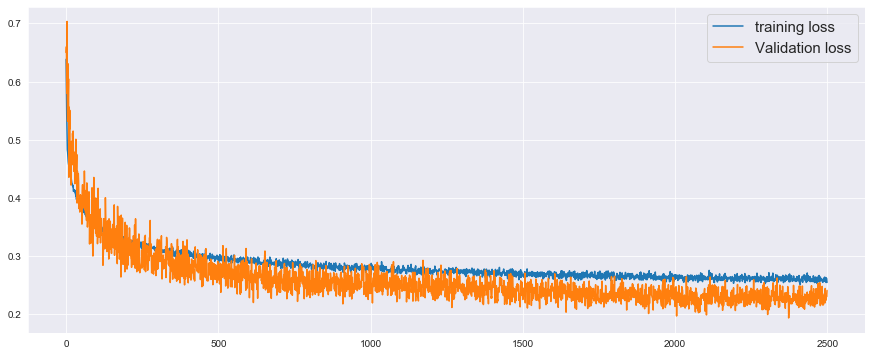

In [546]:
# plot history
fig = plt.figure(figsize=[15,6])
sns.set_style('darkgrid')
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.legend(fontsize=15)
plt.show()

`The curves above shows a good trend with the validation curve below the training curve. There is no indication of overfitting`

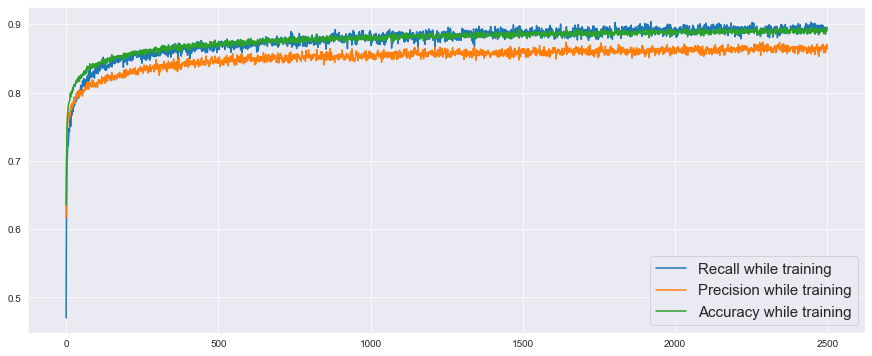

In [547]:
# plot history
fig = plt.figure(figsize=[15,6])
sns.set_style('darkgrid')
plt.plot(history1.history['Recall'], label='Recall while training')
plt.plot(history1.history['Precision'], label='Precision while training')
plt.plot(history1.history['accuracy'], label='Accuracy while training')
plt.legend(fontsize=15)
plt.show()

`There is a great improvement on recall, precision and accuracy. This model would be carried on to prediction`

In [548]:
results1 = model1.evaluate(X_train_res, y_train_res, verbose=0)
print('upsampled training loss is {}'.format(results1[0]))
print()
print('upsampled training Accuracy is {}'.format(results1[1]))
print()
print('upsampled training Recall is {}'.format(results1[2]))
print()
print('upsampled training Precision is {}'.format(results1[3]))
print()
print('upsampled training F1 Score is {}'.format(2*((results1[2])*(results1[3]))/(results1[2]+results1[3])))

upsampled training loss is 0.17223667343925028

upsampled training Accuracy is 0.9435294270515442

upsampled training Recall is 0.9498039484024048

upsampled training Precision is 0.9380325078964233

upsampled training F1 Score is 0.9438815330834436


In [549]:
results1 = model1.evaluate(X_test, y_test.values, verbose=0)
print('test loss is {}'.format(results1[0]))
print()
print('test Accuracy is {}'.format(results1[1]))
print()
print('test Recall is {}'.format(results1[2]))
print()
print('test Precision is {}'.format(results1[3]))
print()
print('test F1 Score is {}'.format(2*((results1[2])*(results1[3]))/(results1[2]+results1[3])))

test loss is 0.48345711433887484

test Accuracy is 0.8034999966621399

test Recall is 0.6359223127365112

test Precision is 0.5188118815422058

test F1 Score is 0.5714285861764671


### Predict the results using 0.5 as a threshold

In [550]:
from sklearn.preprocessing import binarize

`Predict the probabilities of the output using predict_prob function`

In [565]:
Y_pred_prob = model1.predict_proba(X_test, batch_size=50, verbose=0)
Y_pred_prob

array([[0.03596473],
       [0.35882795],
       [0.03097412],
       ...,
       [0.00526285],
       [0.50737405],
       [0.12009875]], dtype=float32)

`implement the treshold of 0.5, i.e predict 1 where the probabilities is >= 0.5 and zero otherwise`

In [552]:
y_pred_class = binarize(Y_pred_prob, 0.5)

### Print the Accuracy score and confusion matrix

In [554]:
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,y_pred_class)))
print('Precision_score: ' + str(precision_score(y_test.values, y_pred_class)))
print('F-score: ' + str(f1_score(y_test.values,y_pred_class)))
confusion_matrix(y_test.values, y_pred_class)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy Model1 (Dropout): 0.8505
Recall_score: 0.6359223300970874
Precision_score: 0.5188118811881188
F-score: 0.5714285714285715


array([[1345,  243],
       [ 150,  262]], dtype=int64)

In [566]:
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

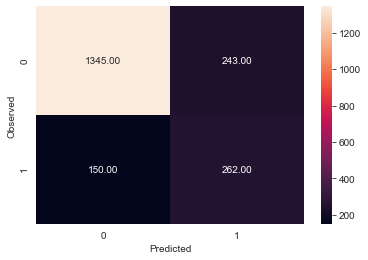

In [567]:
draw_cm(y_test, y_pred_class)